In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import PIL
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout, GroupNormalization, ZeroPadding2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy

E0000 00:00:1730456657.169410      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1101 10:24:17.177713618      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1101 10:24:17.177729590      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1101 10:24:17.177733620      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1101 10:24:17.177736391      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1101 10:24:17.177739102      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print('Error: ', e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1730456713.453210      13 service.cc:145] XLA service 0x583240f02850 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730456713.453265      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1730456713.453270      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1730456713.453273      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1730456713.453276      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1730456713.453279      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1730456713.453281      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1730456713.453284      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1730456713.453287      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [5]:
monet_filenames = tf.io.gfile.glob('/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob('/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(photo_filenames))

n_monet_samples = count_data_items(monet_filenames)
n_photo_samples = count_data_items(photo_filenames)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [6]:
def decode_image(img):
    features = tf.io.parse_single_example(
        img,
        features={
            'image': tf.io.FixedLenFeature([], tf.string)
        }
    )
    image = features['image']
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
    return dataset

def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

In [7]:
monet_ds = load_dataset(monet_filenames).batch(1)
photo_ds = load_dataset(photo_filenames).batch(1)

In [8]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

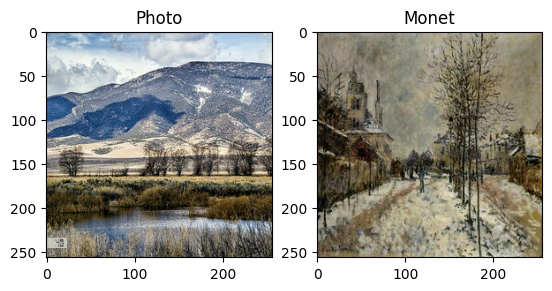

In [9]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [10]:
def Generator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(16, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        Conv2D(32, 4, strides=2, padding='same', activation='leaky_relu'),
        GroupNormalization(groups=-1),
        Conv2DTranspose(32, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    ])
    return model

def Discriminator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(16, 4, strides=2, padding='same', activation='leaky_relu'),
        Conv2D(32, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        ZeroPadding2D(),
        Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu'),
        GroupNormalization(groups=-1),
        ZeroPadding2D(),
        Conv2D(1, 4, strides=1)
    ])
    return model

In [11]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

I0000 00:00:1730456723.818698      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


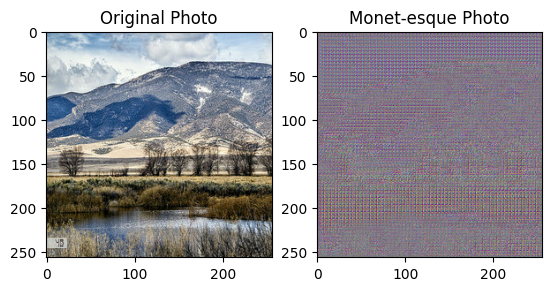

In [12]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title('Original Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title('Monet-esque Photo')
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [13]:
class CycleGan(Model):
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,monet_gen_optimizer,photo_gen_optimizer,monet_disc_optimizer,photo_disc_optimizer,
                generator_loss_fn,discriminator_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = monet_gen_optimizer
        self.p_gen_optimizer = photo_gen_optimizer
        self.m_disc_optimizer = monet_disc_optimizer
        self.p_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = generator_loss_fn
        self.disc_loss_fn = discriminator_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo->Monet->Photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet->Photo->Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator to check, inputting real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator to check, inputting fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Total cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Generator and discriminator gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Applying gradients to optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_disc_loss': monet_disc_loss,
            'photo_disc_loss': photo_disc_loss
        }

In [14]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_loss = real_loss + generated_loss
        return total_loss * 0.5

    def generator_loss(generated):
        loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        return loss

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss
        
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [19]:
with strategy.scope():
    cycle_gan_model = CycleGan(
            monet_generator, photo_generator, monet_discriminator, photo_discriminator
        )

    cycle_gan_model.compile(
        monet_gen_optimizer = monet_generator_optimizer,
        photo_gen_optimizer = photo_generator_optimizer,
        monet_disc_optimizer = monet_discriminator_optimizer,
        photo_disc_optimizer = photo_discriminator_optimizer,
        generator_loss_fn = generator_loss,
        discriminator_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [21]:
history = cycle_gan_model.fit(
    get_gan_dataset(monet_filenames, photo_filenames, batch_size=16), 
    steps_per_epoch=(max(n_monet_samples, n_photo_samples)//4),
    epochs=4
).history 

Epoch 1/4


2024-11-01 10:25:56.147338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1730456756.730588     812 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b33970ff88543e9c:0:0), session_name()
I0000 00:00:1730456790.066987     812 tpu_compile_op_common.cc:245] Compilation of b33970ff88543e9c:0:0 with session name  took 33.336364976s and succeeded
I0000 00:00:1730456790.189272     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b33970ff88543e9c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15706833257698802950", property.function_library_fingerprint = 8451468375168638016, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z 

1759/1759 ━━━━━━━━━━━━━━━━━━━━ 164s 64ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 6.2913 - photo_disc_loss: 0.5543 - photo_gen_loss: 6.4787
Epoch 2/4
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 112s 64ms/step - monet_disc_loss: 0.5611 - monet_gen_loss: 5.4995 - photo_disc_loss: 0.4256 - photo_gen_loss: 5.9639
Epoch 3/4
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 112s 64ms/step - monet_disc_loss: 0.5384 - monet_gen_loss: 5.4005 - photo_disc_loss: 0.3965 - photo_gen_loss: 5.9026
Epoch 4/4
1759/1759 ━━━━━━━━━━━━━━━━━━━━ 112s 64ms/step - monet_disc_loss: 0.5251 - monet_gen_loss: 5.3964 - photo_disc_loss: 0.3779 - photo_gen_loss: 5.9441


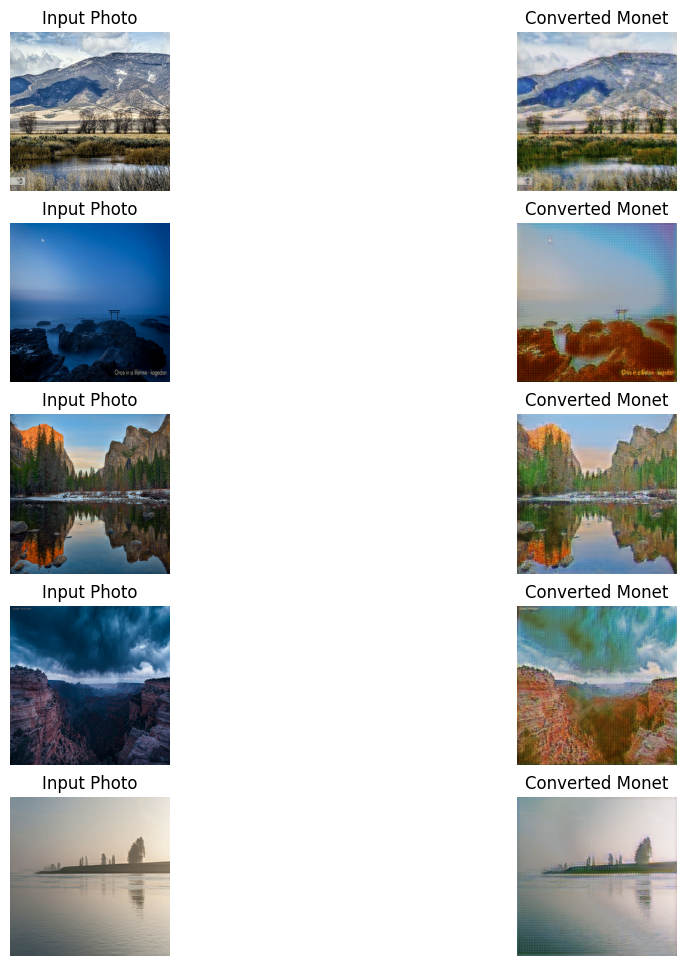

In [22]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title('Input Photo')
    ax[i, 1].set_title('Converted Monet')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()

In [ ]:
! mkdir ../images

In [34]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save('../images/' + str(i) + '.jpg')
    i += 1

In [ ]:
import shutil
shutil.make_archive('/kaggle/working/images', 'zip', '/kaggle/images')